## 1. About the Fashion MNIST Dataset

#### Overview
The Fashion MNIST dataset is a large-scale, publicly available dataset intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Unlike MNIST, which contains images of handwritten digits, Fashion MNIST consists of grayscale images of various types of clothing items.

#### Key Facts
1. **Dataset Composition**:
    - **Number of Samples**: The dataset contains 70,000 images.
    - **Training Set**: 60,000 images.
    - **Test Set**: 10,000 images.
    - **Image Dimensions**: Each image is 28x28 pixels.
    - **Color Channels**: Grayscale (single channel).
    
2. **Classes**:
    - The dataset includes 10 classes of clothing items:
        1. T-shirt/top
        2. Trouser
        3. Pullover
        4. Dress
        5. Coat
        6. Sandal
        7. Shirt
        8. Sneaker
        9. Bag
        10. Ankle boot

3. **Purpose**:
    - Fashion MNIST was created by Zalando Research and released in 2017. It aims to provide a more complex and challenging dataset compared to MNIST to benchmark machine learning algorithms, encouraging researchers to work on models that can generalize better to real-world data.

4. **Format**:
    - The dataset is provided in a similar format to MNIST, making it straightforward to use with many machine learning frameworks that already support the original MNIST dataset.

5. **Usage**:
    - Fashion MNIST can be used for various machine learning tasks, including classification, clustering, and generative modeling.
    - It is widely adopted in educational settings for teaching and learning machine learning concepts.

#### Relevant Sources and Links
1. **Original Paper and Dataset**:
    - [Fashion-MNIST GitHub Repository](https://github.com/zalandoresearch/fashion-mnist): The official GitHub repository containing the dataset and additional resources.
    - [Fashion-MNIST: A Novel Image Dataset for Benchmarking Machine Learning Algorithms](https://arxiv.org/abs/1708.07747): The original paper describing the dataset and its characteristics.

2. **Dataset Hosting**:
    - [Fashion MNIST on Kaggle](https://www.kaggle.com/zalando-research/fashionmnist): A popular hosting site where the dataset is available for download and exploration.
    - [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/fashion_mnist): TensorFlow’s dataset catalog that includes Fashion MNIST, making it easy to load and use with TensorFlow.

3. **Further Reading**:
    - [Deep Learning with Python by François Chollet](https://www.manning.com/books/deep-learning-with-python-second-edition): A comprehensive guide that includes examples and exercises using Fashion MNIST.
    - [Machine Learning Mastery](https://machinelearningmastery.com/): Offers tutorials and articles on how to use Fashion MNIST with various machine learning algorithms and frameworks.

#### Conclusion
The Fashion MNIST dataset is an essential resource for the machine learning community, providing a more challenging alternative to MNIST for benchmarking and educational purposes. Its adoption across various platforms and inclusion in numerous learning resources underscores its importance and utility in advancing machine learning research and education.

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## 2 . Data Augmentation/Cleaning and Image Folder
We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [4]:
from torchvision.transforms import v2
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        v2.Grayscale(),
        ]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        v2.Grayscale(),
        ]),
}

train_data = datasets.FashionMNIST(
    train = True,
    root = 'dataset/',
    download = True,
    transform = data_transforms['train'],
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root="dataset/",
    train=False,
    download=True,
    transform=data_transforms['test'],
    target_transform=None,
)

100%|██████████| 26421880/26421880 [00:07<00:00, 3482271.53it/s] 


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 304251.79it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1206690.88it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8169609.15it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [5]:
class_names = train_data.classes
image , label = train_data[69]
image.shape , label

(torch.Size([1, 28, 28]), 1)

In [6]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

### 2.1 Visualizing data

Text(0.5, 1.0, 'Trouser : 1')

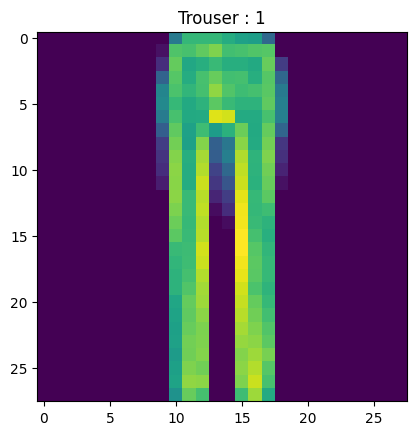

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f'{class_names[label]} : {label}')

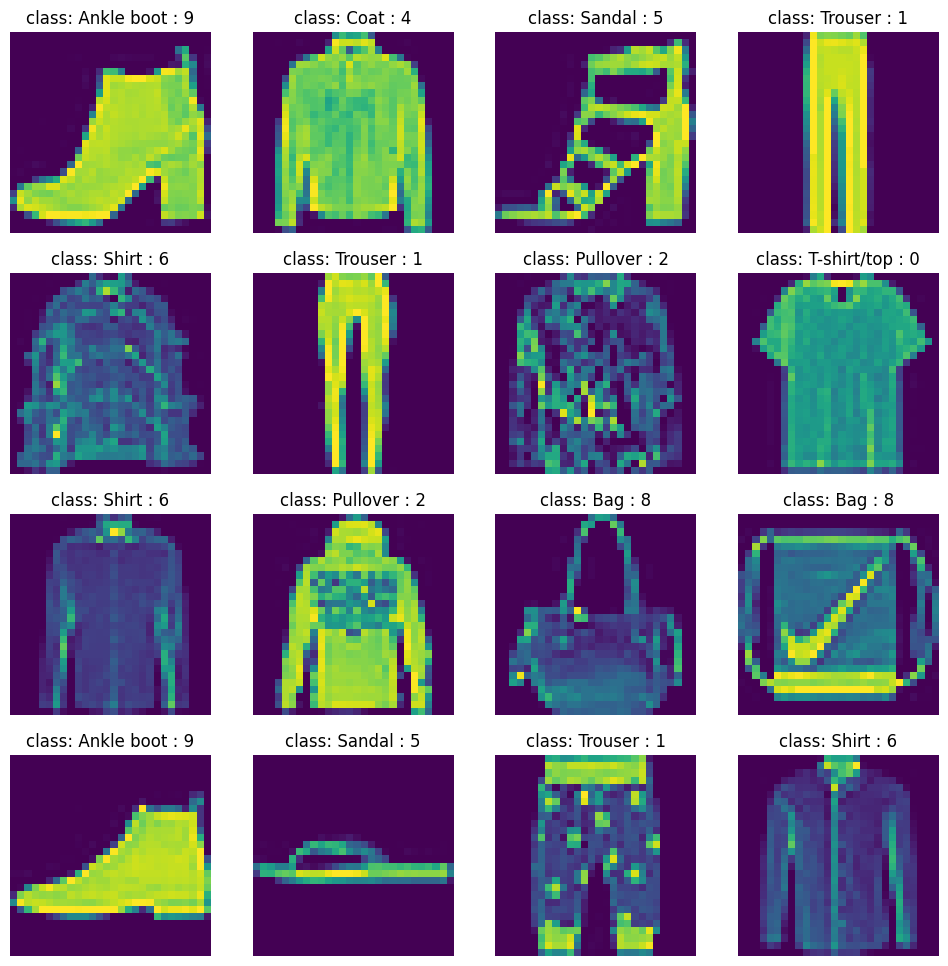

In [9]:
import random
import torch
import matplotlib.pyplot as plt

def plot_random_images(dataset:torch.utils.data.dataset.Dataset ,
                          class_names : list[str] = None,
                          n : int = 3,
                          seed : int = None)->None:
    if seed:
        random.seed(seed)

    fig = plt.figure(figsize=(12, 12))
    for i in range(1,n*n+1):
        random_idx = torch.randint(0 , len(dataset), size = [1]).item()
        image, target = dataset[random_idx]
        fig.add_subplot(n,n,i)
        plt.imshow(image.permute(1,2,0))
        plt.axis(False);
        if class_names:
            title = f"class: {class_names[target]} : {target}"
        else:
            title = None
        plt.title(title)

plot_random_images(dataset = test_data, n = 4 , class_names = class_names )

## 2. Prepare DataLoader

Now we've got a dataset ready to go.

The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or `DataLoader` for short.

The `DataLoader` does what you think it might do.

It helps load data into a model.

For training and for inference.

It turns a large `Dataset` into a Python iterable of smaller chunks.

These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

Why do this?

Because it's more computationally efficient.

In an ideal world you could do the forward pass and backward pass across all of your data at once.

But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

It also gives your model more opportunities to improve.

With **mini-batches** (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?

[32 is a good place to start](https://twitter.com/ylecun/status/989610208497360896?s=20&t=N96J_jotN--PYuJk2WcjMw) for a fair amount of problems.

But since this is a value you can set (a **hyperparameter**) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

![an example of what a batched dataset looks like](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-batching-fashionmnist.png)
*Batching FashionMNIST with a batch size of 32 and shuffle turned on. A similar batching process will occur for other datasets but will differ depending on the batch size.*

Let's create `DataLoader`'s for our training and test sets.

In [10]:
from torch.utils.data import DataLoader
import os
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

In [11]:
len(train_dataloader) , len(test_dataloader)

(469, 79)

## 3. Model : Building a Model | VGGNET11

Using an input image of size 1 x 28 x 28 and applying max pooling only twice, reducing the spatial dimensions from 28 to 14 and then from 14 to 7. Here's the architecture:

1. **Input Layer:**
   - Image size: 3 (channels) x 28 (height) x 28 (width).

2. **Convolutional Layers:**
   - **Conv1:** 64 filters of size 3x3, stride 1, padding 1. Output: 64 x 28 x 28.
   - **Max Pooling:** 2x2, stride 2. Output: 64 x 14 x 14.
   
   - **Conv2:** 128 filters of size 3x3, stride 1, padding 1. Output: 128 x 14 x 14.
   - **Max Pooling:** 2x2, stride 2. Output: 128 x 7 x 7.
   
   - **Conv3:** 256 filters of size 3x3, stride 1, padding 1. Output: 256 x 7 x 7.
   - **Conv4:** 256 filters of size 3x3, stride 1, padding 1. Output: 256 x 7 x 7.
   
   - **Conv5:** 512 filters of size 3x3, stride 1, padding 1. Output: 512 x 7 x 7.
   - **Conv6:** 512 filters of size 3x3, stride 1, padding 1. Output: 512 x 7 x 7.
   
   - **Conv7:** 512 filters of size 3x3, stride 1, padding 1. Output: 512 x 7 x 7.

   - **AvgPool:** 512 filters of size 7x7, stride 7, padding 1. Output: 512 x 1 x 1.

3. **Fully Connected Layers:**
   - **FC6:** Flattening the output from the convolutional layers (512 x 1 x  = 512) and then a fully connected layer with 4096 units.
   - **FC7:** Fully connected layer with 4096 units.
   - **FC8:** Fully connected layer with the number of units corresponding to the number of classes (e.g., 1000 for ImageNet; this can be adjusted based on the specific task).

4. **Output Layer:**
   - Softmax layer to produce probabilities for each class.

### Summary:
- **Input:** 3 x 28 x 28
- **Conv1:** 64 x 28 x 28 → Max Pooling → 64 x 14 x 14
- **Conv2:** 128 x 14 x 14 → Max Pooling → 128 x 7 x 7
- **Conv3:** 256 x 7 x 7
- **Conv4:** 256 x 7 x 7
- **Conv5:** 512 x 7 x 7
- **Conv6:** 512 x 7 x 7
- **Conv7:** 512 x 7 x 7
- **AvgPool:** 512 x 1 x 1
- **Flatten:** 512 x 1 x 1 = 512
- **FC6:** 4096
- **FC7:** 4096
- **FC8:** Number of classes (e.g., 10)
- **Output:** Softmax layer

This modified VGGNet-11 architecture adapts to the smaller input size while maintaining the overall design principles of the VGG network.

<img src = 'https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/network.png'>

In [61]:
import torch
import torch.nn as nn

# Architecture : [64 , 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
class VGGNet11(nn.Module):
    def __init__(self, in_channels =3 , num_classes = 10):
        super(VGGNet11,self).__init__()

        self.ConvBlock1 = self._create_block(in_channels=in_channels , out_channels=64 )

        self.ConvBlock2 = self._create_block(in_channels=64 , out_channels=128, pool = True)

        self.ConvBlock3 = self._create_block(in_channels=128 , out_channels=256)
        self.ConvBlock4 = self._create_block(in_channels=256 , out_channels=256)

        self.ConvBlock5 = self._create_block(in_channels=256 , out_channels=512)
        self.ConvBlock6 = self._create_block(in_channels=512 , out_channels=512, pool=True)

        self.ConvBlock7 = self._create_block(in_channels=512 , out_channels=512)
        self.ConvBlock8 = self._create_block(in_channels=512 , out_channels=512)
        
        self.AvgPool = nn.AdaptiveAvgPool2d(1)

        self.FC = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512 , out_features=4096),
            nn.ReLU(inplace=True ),
            nn.Dropout(0.4),
            nn.Linear(4096 , 4096),
            nn.ReLU(inplace=True ),
            nn.Dropout(0.4),
            nn.Linear(4096 , num_classes)

        )

    def forward(self , x):
        x = self.ConvBlock1(x)
        x = self.ConvBlock2(x)
        x = self.ConvBlock3(x)
        x = self.ConvBlock4(x)
        x = self.ConvBlock5(x)
        x = self.ConvBlock6(x)
        x = self.ConvBlock7(x)
        x = self.ConvBlock8(x)
        x = self.AvgPool(x)
        x = self.FC(x)
        return x

    def _create_block(self,in_channels , out_channels , pool = False):
        layer = []
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels , out_channels=out_channels , kernel_size=(3,3) ,stride=1 , padding=1 , bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        layer.append(block)

        if  pool == True :layer.append(nn.MaxPool2d(kernel_size=(2,2) , stride=2))
        return nn.Sequential(*layer)

model = VGGNet11(in_channels = 1 , num_classes = len(class_names)).to(device)
model

VGGNet11(
  (ConvBlock1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (ConvBlock2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvBlock3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (ConvBlock4):

In [62]:
!pip install torchinfo --q
from torchinfo import summary
summary(model,input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet11                                 [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-1                  [32, 64, 28, 28]          576
│    │    └─BatchNorm2d: 3-2             [32, 64, 28, 28]          128
│    │    └─LeakyReLU: 3-3               [32, 64, 28, 28]          --
├─Sequential: 1-2                        [32, 128, 14, 14]         --
│    └─Sequential: 2-2                   [32, 128, 28, 28]         --
│    │    └─Conv2d: 3-4                  [32, 128, 28, 28]         73,728
│    │    └─BatchNorm2d: 3-5             [32, 128, 28, 28]         256
│    │    └─LeakyReLU: 3-6               [32, 128, 28, 28]         --
│    └─MaxPool2d: 2-3                    [32, 128, 14, 14]         --
├─Sequential: 1-3                        [32, 256, 14, 14]         --
│    └─S

## 4 Functionizing training and test loops

So far we've been writing train and test loops over and over.

Let's write them again but this time we'll put them in functions so they can be called again and again.

And because we're using device-agnostic code now, we'll be sure to call `.to(device)` on our feature (`X`) and target (`y`) tensors.

For the training loop we'll create a function called `train()` which takes in a model, a `DataLoader` a loss function and an optimizer.

The testing loop will be similar but it'll be called `evaluate()` and it'll take in a model, a `DataLoader`, a loss function and an evaluation function.

> **Note:** Since these are functions, you can customize them in any way you like. What we're making here can be considered barebones training and testing functions for our specific classification use case.

In [63]:
def train(model:torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          criterion:torch.nn.Module,
          device = device):

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss =  criterion(output, target)

        loss.backward()

        optimizer.step()

In [64]:
def evaluate(model:torch.nn.Module,
              test_loader:torch.utils.data.DataLoader,
              criterion:torch.nn.Module,
              device = device):

    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():

        for data, target in test_loader:

            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target).item()

            pred = output.max(1, keepdim=True)[1]

            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 5. Creating a `train_model()` function to combine `train()` and `evaluate()`

Now we need a way to put our `train()` and `evaluate()` functions together.

To do so, we'll package them up in a `train_model()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm) is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [65]:
import time
import copy

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

def train_model(model:torch.nn.Module,
                train_loader:torch.utils.data.DataLoader,
                val_loader:torch.utils.data.DataLoader,
                optimizer:torch.optim.Optimizer,
                criterion:torch.nn.Module ,
                num_epochs:int,
                device:torch.device = device):

    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 

    for epoch in range(1, num_epochs + 1):
        since = time.time()  

        train(model, train_loader, optimizer , criterion)

        train_loss, train_acc = evaluate(model, train_loader , criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(val_loss)
        results["test_acc"].append(val_acc)

        time_elapsed = time.time() - since  

        print('-------------- EPOCH {} ----------------'.format(epoch))
        print('Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print('Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()

    model.load_state_dict(best_model_wts)

    return model

## 6 Train and Evaluate Model 

Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `ResNet18` model, `DataLoader`'s and `train()` function together 

To keep our experiments quick, we'll train our model for **25 epochs** 

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `1e-4` respecitvely.

In [66]:
epoch = 40
learning_rate = 3e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate , betas = (0.5 , 0.999))

model = train_model(model, train_dataloader, test_dataloader, optimizer, criterion ,epoch)

-------------- EPOCH 1 ----------------
Train Loss: 0.0031, Accuracy: 85.30%
Val Loss: 0.0034, Accuracy: 84.35%
Time: 0m 43s

-------------- EPOCH 2 ----------------
Train Loss: 0.0025, Accuracy: 88.45%
Val Loss: 0.0028, Accuracy: 87.08%
Time: 0m 43s

-------------- EPOCH 3 ----------------
Train Loss: 0.0016, Accuracy: 92.36%
Val Loss: 0.0020, Accuracy: 90.82%
Time: 0m 43s

-------------- EPOCH 4 ----------------
Train Loss: 0.0044, Accuracy: 82.87%
Val Loss: 0.0048, Accuracy: 82.00%
Time: 0m 43s

-------------- EPOCH 5 ----------------
Train Loss: 0.0015, Accuracy: 92.60%
Val Loss: 0.0019, Accuracy: 91.03%
Time: 0m 43s

-------------- EPOCH 6 ----------------
Train Loss: 0.0016, Accuracy: 92.56%
Val Loss: 0.0021, Accuracy: 90.45%
Time: 0m 43s

-------------- EPOCH 7 ----------------
Train Loss: 0.0018, Accuracy: 91.77%
Val Loss: 0.0023, Accuracy: 89.76%
Time: 0m 43s

-------------- EPOCH 8 ----------------
Train Loss: 0.0016, Accuracy: 92.76%
Val Loss: 0.0024, Accuracy: 90.27%
Time: 

## 7. Plot the loss curves of Model

From the print outs of our `model` training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's **loss curves**. 

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `results` dictionary.

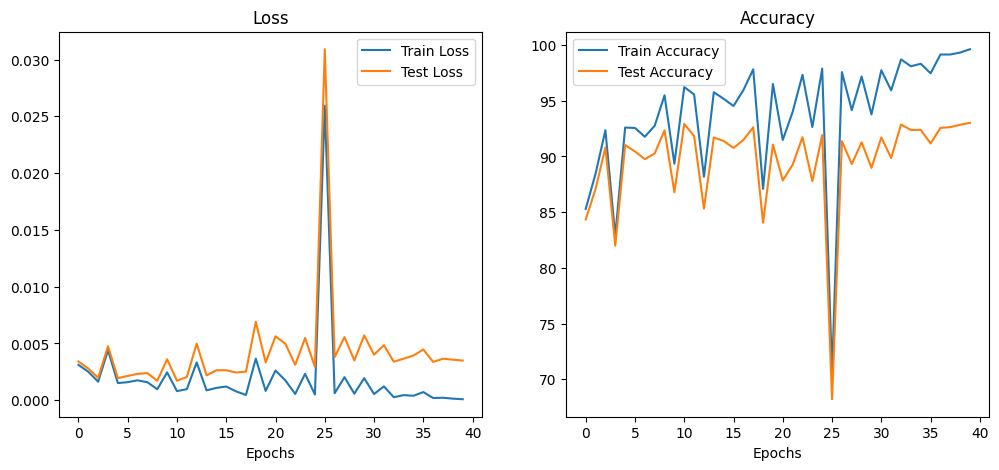

In [67]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(results)

### 7.1 Evaluate Model

In [68]:
model.eval()

_, train_acc = evaluate(model, train_dataloader , criterion)
_, test_acc = evaluate(model, test_dataloader, criterion)

print('Train Accuracy: {:.4f}%'.format(train_acc))
print('Test Accuracy: {:.4f}%'.format(test_acc))

Train Accuracy: 99.6250%
Test Accuracy: 93.0200%


## 8. Making Random Prediction on Test Dataset and Plotting Them

In [69]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:

            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

test_labels, pred_classes

([9, 5, 5, 4, 6, 2, 5, 8, 1, 6, 4, 9, 5, 2, 0, 0],
 tensor([9, 5, 5, 4, 2, 2, 5, 8, 1, 6, 4, 9, 5, 2, 0, 0]))

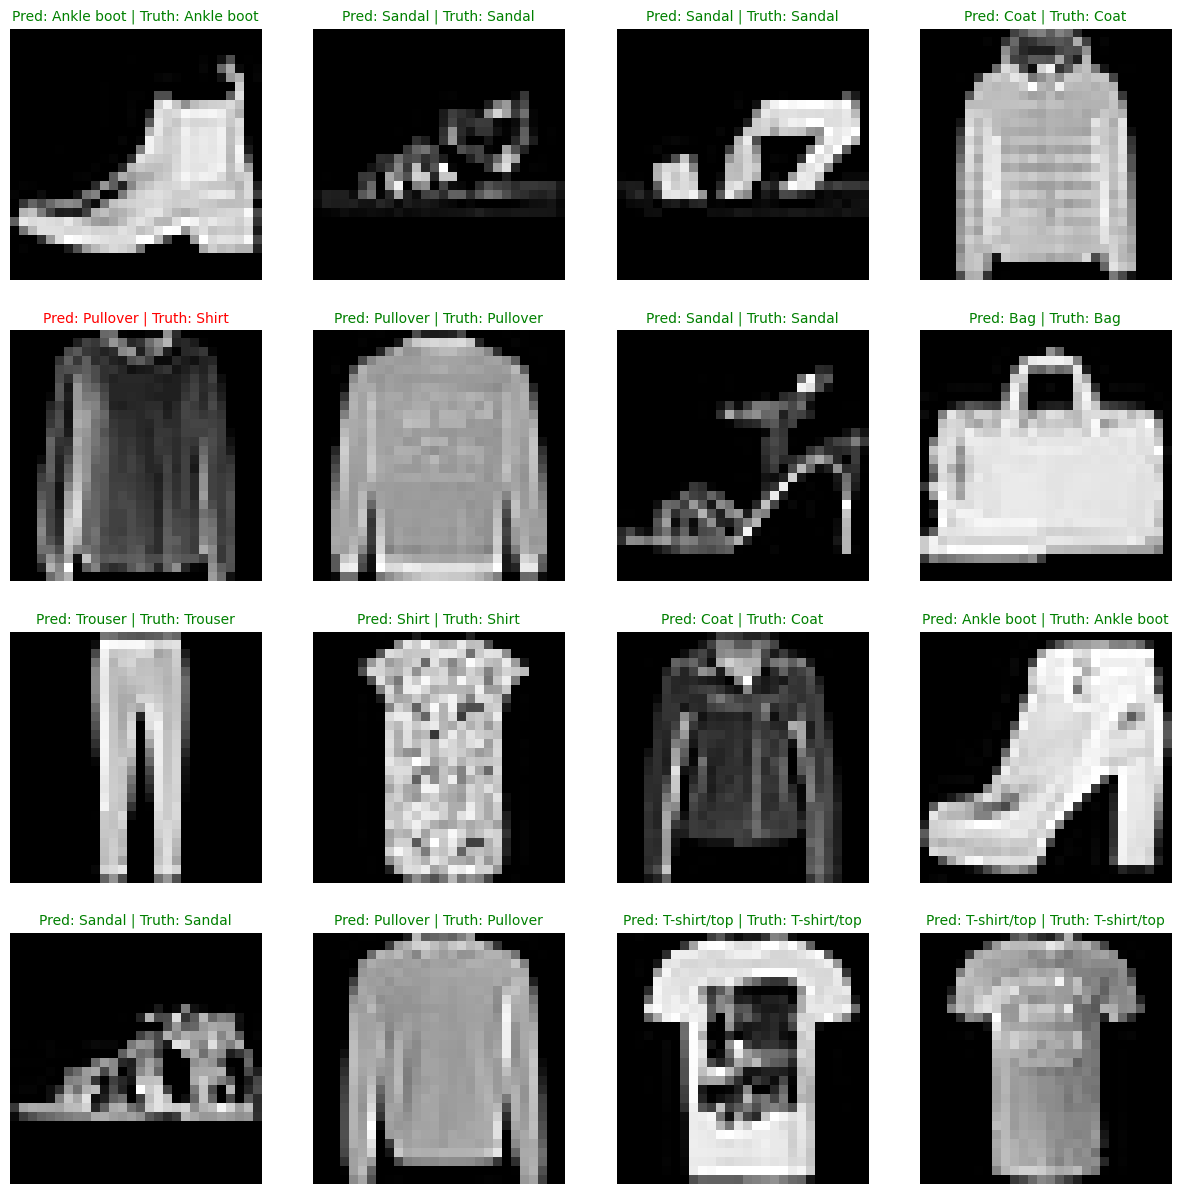

In [70]:
def plot_predicted_images(samples : list ,
                          test_targets : torch.Tensor ,
                          test_preds : torch.Tensor,
                          class_names : list,
                          rows : int = 4,
                          cols : int = 4):

    plt.figure(figsize=(15, 15))
    for i, sample in enumerate(samples):
      plt.subplot(rows, cols, i+1)
      plt.imshow(sample.permute(1,2,0), cmap="gray")
      pred_label = class_names[test_preds[i]]
      truth_label = class_names[test_targets[i]]

      title_text = f"Pred: {pred_label} | Truth: {truth_label}"
      if pred_label == truth_label:
          plt.title(title_text, fontsize=10, c="g")
      else:
          plt.title(title_text, fontsize=10, c="r")
      plt.axis(False);

plot_predicted_images(test_samples, test_labels , pred_classes , class_names )

In [71]:
def get_preds(model , dataloader , device = device):
    from tqdm.auto import tqdm
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):

            X, y = X.to(device), y.to(device)

            y_logit = model(X)

            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            y_preds.append(y_pred.cpu())

    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor

test_preds = get_preds(model , test_dataloader)
len(test_preds)

Making predictions:   0%|          | 0/79 [00:00<?, ?it/s]

10000

## 9. Classification Report

In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

test_targets = [label for image , label  in test_data]

print(f'Test Accuarcy : {accuracy_score(test_targets, test_preds)*100}%')

Test Accuarcy : 93.02%


In [73]:
from sklearn.metrics import classification_report
print('------------------------------------------------------------')
test_report = classification_report(test_targets, test_preds)
print(f'Classification Report : Test Dataset')
print(test_report)

------------------------------------------------------------
Classification Report : Test Dataset
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.91      0.90      1000
           3       0.95      0.91      0.93      1000
           4       0.84      0.94      0.89      1000
           5       0.99      0.99      0.99      1000
           6       0.84      0.72      0.78      1000
           7       0.97      0.98      0.98      1000
           8       0.99      0.98      0.99      1000
           9       0.98      0.97      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## 10. Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics](https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics) we can use for classification problems.

One of the most visual is a [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:
* Plot the confusion matrix using `scikit-learn` confusion_matrix and `seaborn`.


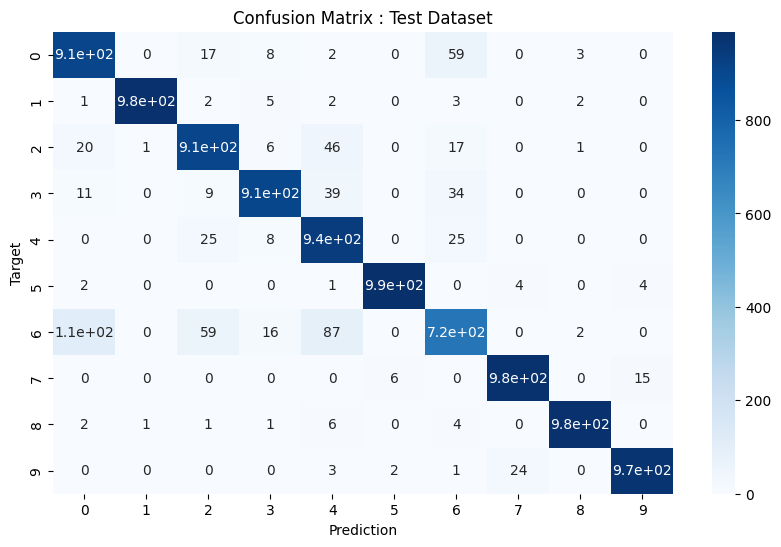

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(title: str ,targets:torch.Tensor , preds : torch.Tensor):
    cf = confusion_matrix(targets, preds)
    plt.figure(figsize=(10,6))
    sns.heatmap(cf , annot=True , cmap = 'Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'Confusion Matrix : {title}')
    plt.show()

plot_confusion_matrix(title = 'Test Dataset' ,preds = test_preds , targets = test_targets )

## 11. Save and load best performing model

Let's finish this section off by saving and loading in our best performing model.

* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `model0`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.

In [78]:
from pathlib import Path

MODEL_PATH = Path("pytorch saved model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: pytorch saved model/FashionMNIST2.pth


In [76]:
loaded_model = model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model = loaded_model.to(device)

In [77]:
loaded_model.eval()

_, train_acc = evaluate(loaded_model, train_dataloader , criterion)

_, test_acc = evaluate(loaded_model, test_dataloader, criterion)

print('Train Accuracy: {:.4f}%'.format(train_acc))
print('Test Accuracy: {:.4f}%'.format(test_acc))

Train Accuracy: 99.6250%
Test Accuracy: 93.0200%
